## Imports

In [1]:
from nb_utils import set_root

PROJECT_DIR = set_root(4)

In [2]:
import warnings
from functools import partial
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, cohen_kappa_score, f1_score,
                             precision_score, recall_score)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from src.mlpr.ml.supervisioned.classification.uncertainty import \
    UncertaintyPlots
from src.mlpr.ml.supervisioned.classification.utils import (calculate_probas,
                                                            generate_colors)
from src.mlpr.ml.supervisioned.tunning.grid_search import GridSearch

warnings.filterwarnings("ignore")

%reload_ext autoreload

## Parameters

In [3]:
random_state: int = 42
n_feats: int = 2
n_size: int = 1000
centers: list[tuple] = [
    (0, 2),
    (2, 0),
    (5, 4.5)
]
n_class: int = len(centers)
cluster_std: list[float] = [1.4, 1.4, 0.8]
cv: int = 5
np.random.seed(random_state)

In [4]:
params: dict[str, dict[str, any]] = {
    "n_samples": n_size,
    "n_features": n_feats,
    "centers": centers,
    "cluster_std": cluster_std,
    "random_state": random_state
}

In [5]:
np.random.seed(random_state)

In [6]:
params_split: dict[str, float | int] = {
    'test_size': 0.25,
    'random_state': random_state
}
params_norm: dict[str, bool] = {'with_mean': True, 'with_std': True}

model_metrics: dict[str, any] = {
    'custom_accuracy': partial(accuracy_score, normalize=False),
    'accuracy': accuracy_score,
    'precision': partial(precision_score, average='macro'),
    'recall': partial(recall_score, average='macro'),
    'kappa': cohen_kappa_score,
    'f1': partial(f1_score, average='macro'),
}

## Loading the Data

In [7]:
X, y = make_blobs(
    **params
)

## Plot dataset

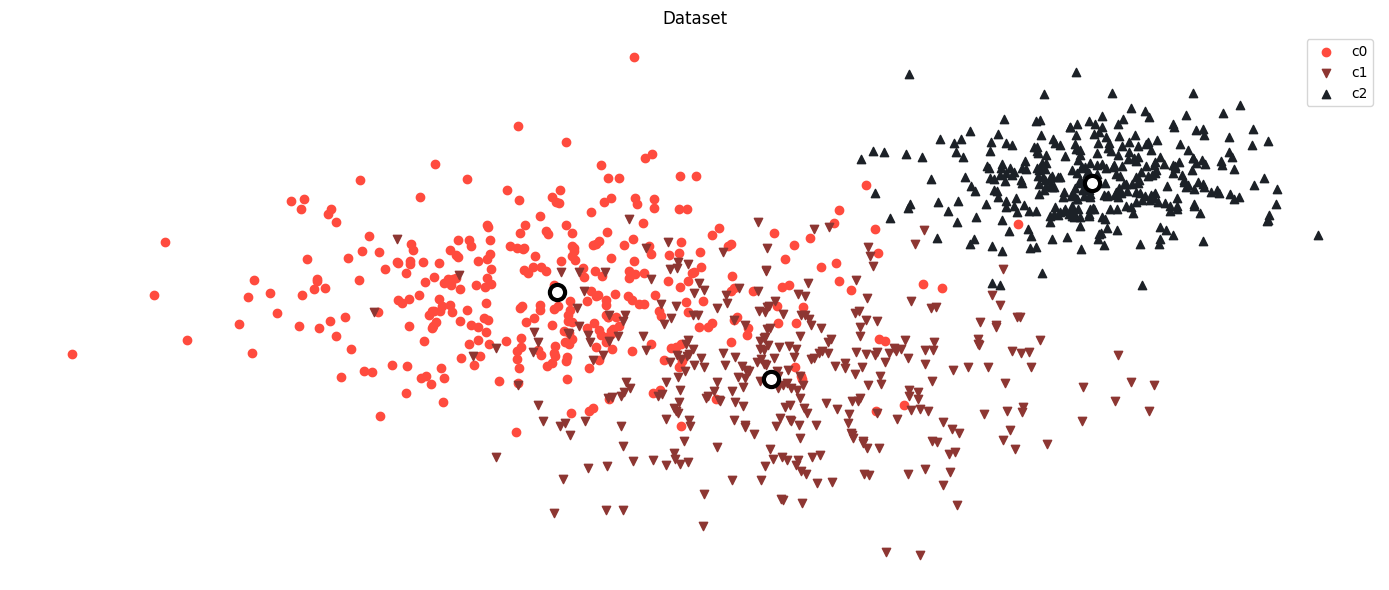

In [8]:
markers = ['o', 'v', '^']
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

colors = generate_colors("FF4B3E", "1C2127", len(np.unique(y)))

for i, k in enumerate(np.unique(y)):
    ax.scatter(
        X[:, 0][y == k],
        X[:, 1][y == k],
        marker=markers[i % len(markers)],
        color=colors[i],
        label=f"c{i}"
    )

ax.set_title("Dataset")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
for center, color in zip(centers, colors):
    ax.scatter(
        center[0],
        center[1],
        color="white",
        linewidths=3,
        marker="o",
        edgecolor="black",
        s=120
    )
plt.legend()
fig.savefig(PROJECT_DIR / "assets" / "classification_scatter.png", dpi=400)
fig.tight_layout()

## Cross-validation

In [9]:
models: Dict[BaseEstimator, Dict] = {
    RandomForestClassifier: {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [random_state]
    },
    GradientBoostingClassifier: {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01, 0.005],
        'subsample': [0.5, 0.8, 1.0],
        'random_state': [random_state]
    },
    LogisticRegression: {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'random_state': [random_state],
        'max_iter': [10000]
    },
    GaussianNB: {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    SVC: {
        'C': [0.01, 0.1, 1.0, 10.0],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'probability': [True],
        'random_state': [random_state]
    },
    DecisionTreeClassifier: {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [random_state]
    }
}

In [10]:
grid_search = GridSearch(
    X,
    y,
    params_split=params_split,
    models_params=models,
    normalize=True,
    params_norm=params_norm,
    scoring='accuracy',
    metrics=model_metrics
)
grid_search.search(cv=cv, n_jobs=-1)

best_model, best_params = \
    grid_search \
    .get_best_model()

100%|██████████| 6/6 [01:16<00:00, 12.67s/it]


In [11]:
results: pd.DataFrame = pd.DataFrame(grid_search._metrics).T
results

,custom_accuracy,accuracy,precision,recall,kappa,f1
RandomForestClassifier,222.0,0.888,0.883566,0.885902,0.831666,0.882724
GradientBoostingClassifier,221.0,0.884,0.878830,0.881207,0.825583,0.878421
LogisticRegression,230.0,0.920,0.915170,0.916987,0.879457,0.915662
GaussianNB,231.0,0.924,0.919375,0.921682,0.885539,0.920046
SVC,230.0,0.920,0.915170,0.916987,0.879457,0.915662
DecisionTreeClassifier,214.0,0.856,0.848155,0.845622,0.782325,0.846414


## Probabilities

In [12]:
probas = calculate_probas(grid_search.fitted, grid_search.X_train)

## Plot best model result

In [13]:
up = UncertaintyPlots()

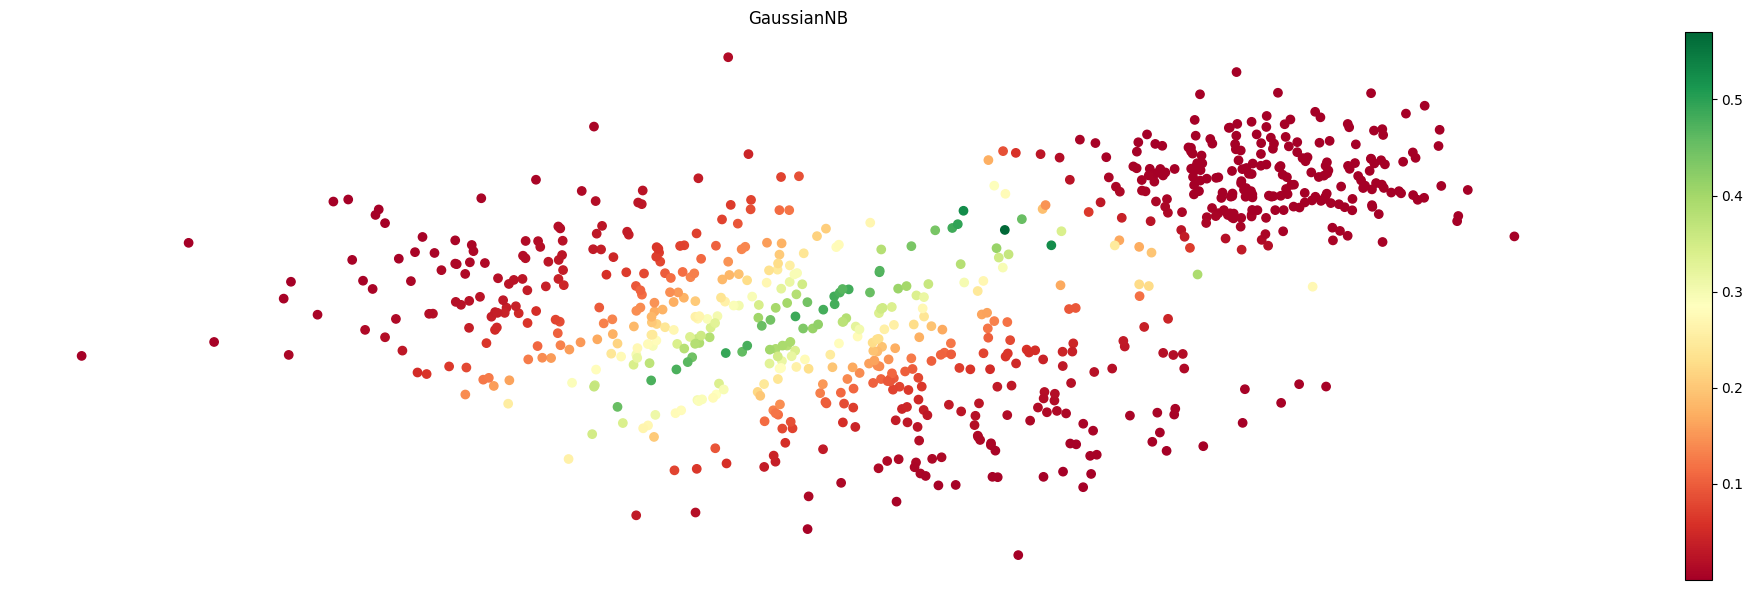

In [14]:
fig_un, ax_un = up.uncertainty(
    model_names=[[best_model.__class__.__name__]],
    probs={best_model.__class__.__name__: probas[best_model.__class__.__name__]},
    X=grid_search.X_train,
    figsize=(20, 6),
    cmap='RdYlGn',
    show_inline=True,
    box_on=False
)
fig_un.savefig(PROJECT_DIR / "assets" / "classification_uncertain_best.png", dpi=400)

## Plot overall of uncertainty

In [15]:
sorted_models = results.sort_values("accuracy", ascending=False).index.tolist()

pyramid = []
i = 0
for row in range(1, len(sorted_models)):
    if i + row <= len(sorted_models):
        pyramid.append(sorted_models[i:i + row])
        i += row
    else:
        break

if i < len(sorted_models):
    pyramid.append(sorted_models[i:])

if len(pyramid[-1]) < len(pyramid[-2]):
    pyramid[-2].extend(pyramid[-1])
    pyramid = pyramid[:-1]

In [16]:
up = UncertaintyPlots()

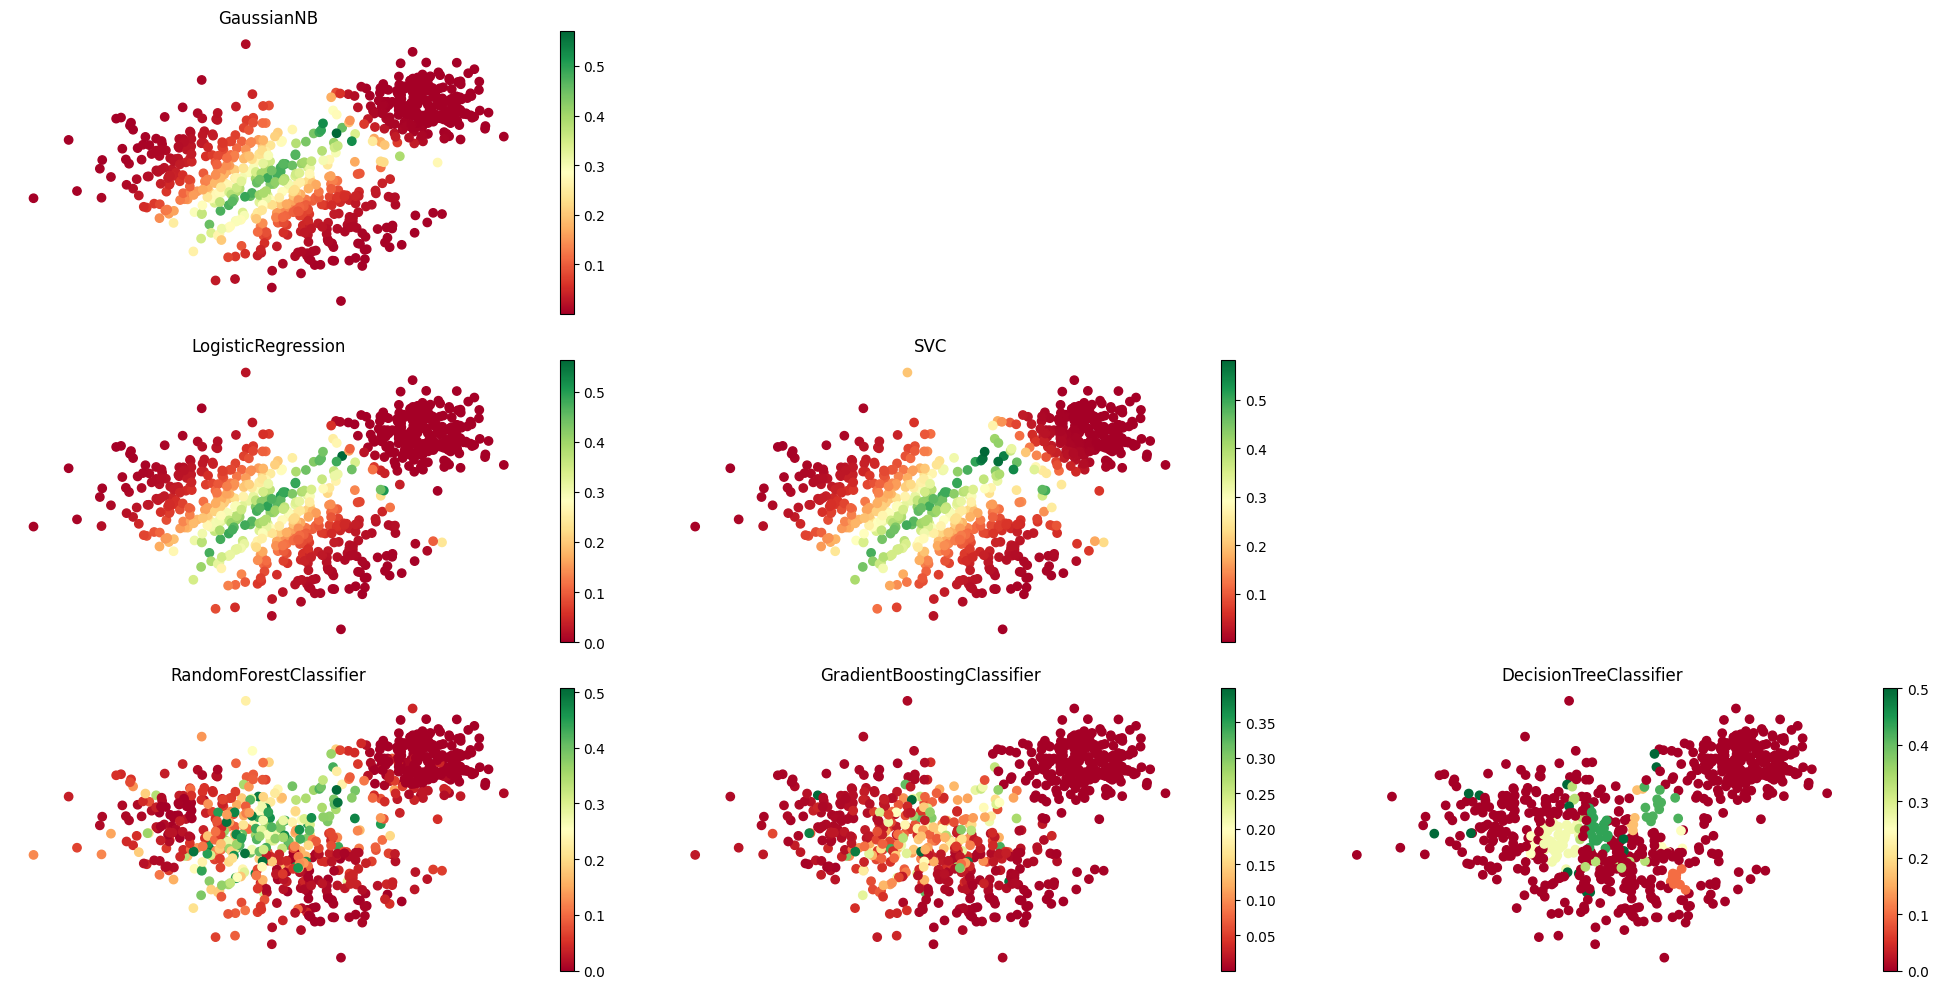

In [17]:
fig_un, ax_un = up.uncertainty(
    model_names=pyramid,
    probs=probas,
    X=grid_search.X_train,
    figsize=(20, 10),
    show_inline=True,
    cmap='RdYlGn',
    box_on=False
)
fig_un.savefig(PROJECT_DIR / "assets" / "classification_uncertain_pyramid.png", dpi=400)

## Aleatory uncertainty and Epistemic uncertainty

In [18]:
data_probas = pd.DataFrame(probas)
random: pd.Series = data_probas.mean(axis=1)
epistemic: pd.Series = data_probas.var(axis=1)

In [19]:
up = UncertaintyPlots()

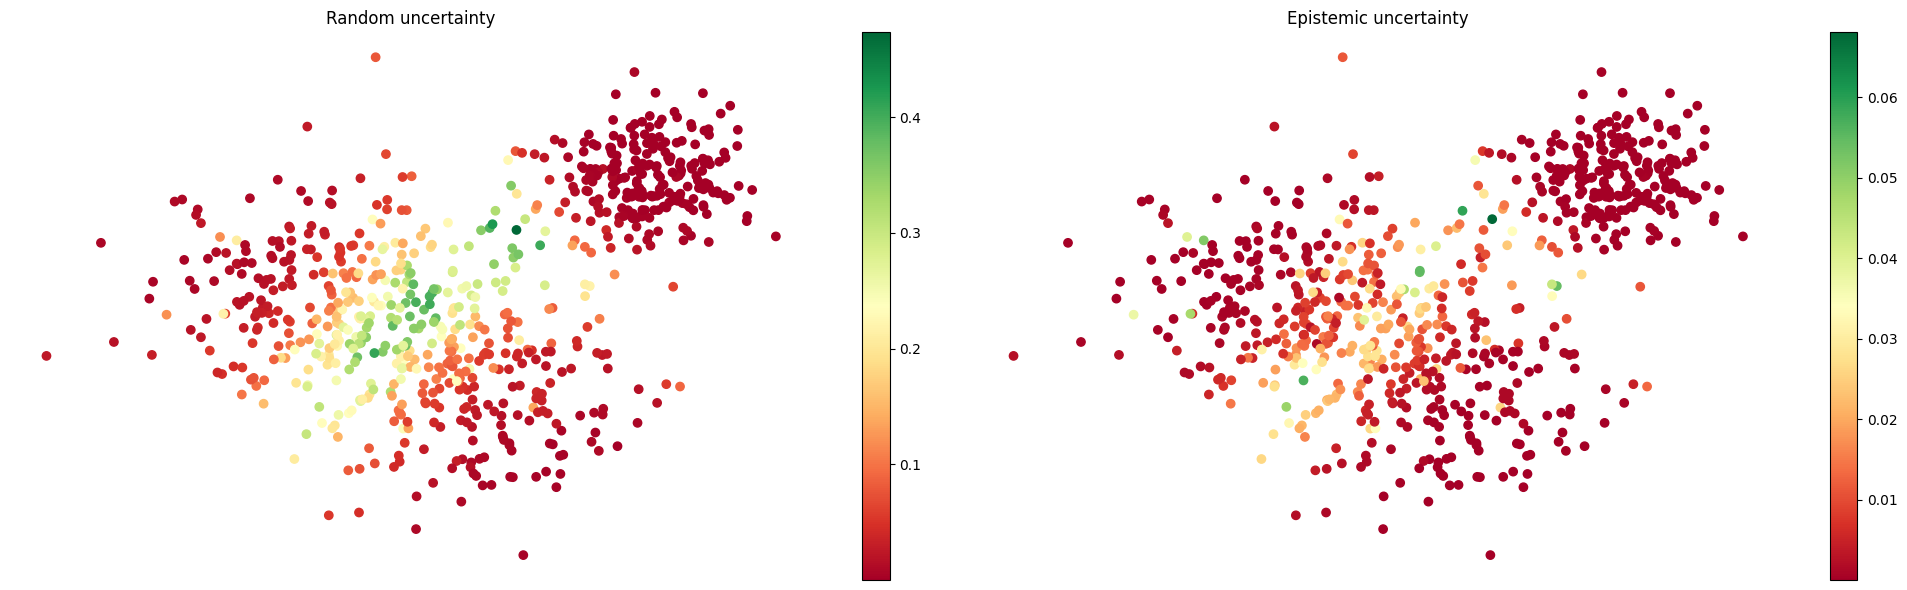

In [20]:
fig_both, ax_both = up.uncertainty(
    model_names=[["Random uncertainty", "Epistemic uncertainty"]],
    probs={
        "Random uncertainty": random,
        "Epistemic uncertainty": epistemic
    },
    X=grid_search.X_train,
    figsize=(20, 6),
    cmap='RdYlGn',
    show_inline=True,
    box_on=False
)
fig_both.savefig(PROJECT_DIR / "assets" / "classification_uncertain_aleatory_epistemic.png", dpi=400)